In [12]:
#Import and Load Dataset

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import plotly.express as px
from pandas.tseries.offsets import MonthBegin
import joblib

# Load cleaned monthly dataset
df = pd.read_csv("../data/car_sales_clean.csv")

# Convert date column
df["date"] = pd.to_datetime(df["date"])

# Sort by date (important)
df = df.sort_values("date")

df.head()


,ym,branch,model,units_sold,avg_price,date
0,2008-02,Mercury,Mountaineer,27.609,27.560,2008-02-01
1,2009-10,Mercury,Villager,20.380,22.510,2009-10-01
2,2009-10,Oldsmobile,Alero,80.255,18.270,2009-10-01
3,2011-01,Mercedes-B,SLK,7.998,38.900,2011-01-01
4,2011-01,Nissan,Xterra,54.158,22.799,2011-01-01


In [13]:
# Time-based features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Seasonal cyclical encoding
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


In [14]:
# Turn branch and model into dummies
df = pd.get_dummies(df, columns=["branch", "model"], drop_first=True)

df.head()


,ym,units_sold,avg_price,date,year,month,month_sin,month_cos,branch_Audi,branch_BMW,branch_Buick,branch_Cadillac,branch_Chevrolet,branch_Chrysler,branch_Dodge,branch_Ford,branch_Honda,branch_Hyundai,branch_Infiniti,branch_Jaguar,branch_Jeep,branch_Lexus,branch_Lincoln,branch_Mercedes-B,branch_Mercury,branch_Mitsubishi,branch_Nissan,branch_Oldsmobile,branch_Plymouth,branch_Pontiac,branch_Porsche,branch_Saab,branch_Saturn,branch_Subaru,branch_Toyota,branch_Volkswagen,branch_Volvo,model_3000GT,model_300M,model_323i,model_328i,model_4Runner,model_5-Sep,model_528i,model_A4,model_A6,model_A8,model_Accent,model_Accord,model_Alero,model_Altima,model_Aurora,model_Avalon,model_Avenger,model_Beetle,model_Bonneville,model_Boxter,model_Bravada,model_Breeze,model_C-Class,...,model_Montana,model_Monte Carlo,model_Montero,model_Montero Sport,model_Mountaineer,model_Mustang,model_Mystique,model_Navigator,model_Neon,model_Odyssey,model_Outback,model_Park Avenue,model_Passat,model_Passport,model_Pathfinder,model_Prizm,model_Prowler,model_Quest,model_RAV4,model_RL,model_RX300,model_Ram Pickup,model_Ram Van,model_Ram Wagon,model_Ranger,model_Regal,model_S-Class,model_S-Type,model_S40,model_S70,model_S80,model_SC,model_SL,model_SL-Class,model_SLK,model_SLK230,model_SW,model_Sable,model_Sebring Conv.,model_Sebring Coupe,model_Sentra,model_Seville,model_Sienna,model_Silhouette,model_Sonata,model_Stratus,model_Sunfire,model_TL,model_Tacoma,model_Taurus,model_Town & Country,model_Town car,model_V40,model_V70,model_Villager,model_Viper,model_Voyager,model_Windstar,model_Wrangler,model_Xterra
0,2008-02,27.609,27.560,2008-02-01,2008,2,0.866025,0.500000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2009-10,20.380,22.510,2009-10-01,2009,10,-0.866025,0.500000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,2009-10,80.255,18.270,2009-10-01,2009,10,-0.866025,0.500000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2011-01,7.998,38.900,2011-01-01,2011,1,0.500000,0.866025,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,

In [15]:
# Use ALL columns except these
features = [c for c in df.columns if c not in ["units_sold", "date", "ym"]]

X = df[features]
y = df["units_sold"]

# Time-based split: NO shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

len(X_train), len(X_test)


(125, 32)

In [16]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 45.515493104696276
R²: 0.27420297879371724


In [ ]:
df.columns.tolist()


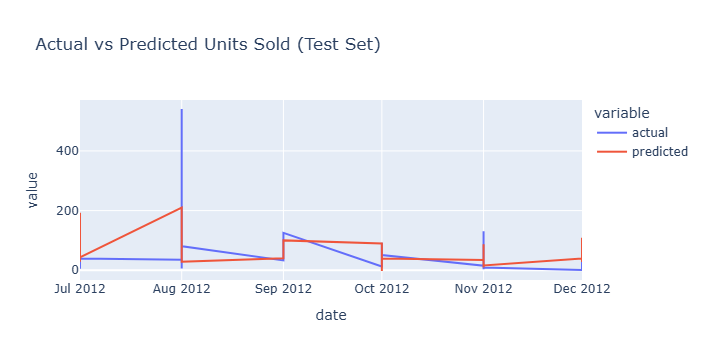

In [17]:
#Visualize actual and predicted sales
test_plot = pd.DataFrame({
    "date": df["date"].iloc[-len(y_test):],
    "actual": y_test.values,
    "predicted": y_pred
})

fig = px.line(test_plot, x="date", y=["actual", "predicted"],
              title="Actual vs Predicted Units Sold (Test Set)")
fig.show()


In [18]:
#3 month forecast

# 1. Last date in dataset
last_date = df["date"].max()

# 2. Create next 3 months
future_months = pd.date_range(last_date + MonthBegin(1), periods=3, freq="MS")

# 3. Select all rows for the last month (preserves branch/model dummies)
last_month_rows = df[df["date"] == last_date].copy()

future_frames = []

# 4. Create forecast rows
for d in future_months:
    temp = last_month_rows.copy()
    temp["date"] = d
    temp["year"] = d.year
    temp["month"] = d.month
    temp["month_sin"] = np.sin(2 * np.pi * temp["month"] / 12)
    temp["month_cos"] = np.cos(2 * np.pi * temp["month"] / 12)
    future_frames.append(temp)

# 5. Combine
future_all = pd.concat(future_frames, ignore_index=True)

# 6. Predict using the model
future_all["forecast_units"] = xgb.predict(future_all[features])

# 7. Clean output
cols_to_keep = ["date", "forecast_units"] + \
               [c for c in df.columns if c.startswith("branch_") or c.startswith("model_")]

future_output = future_all[cols_to_keep]

future_output


,date,forecast_units,branch_Audi,branch_BMW,branch_Buick,branch_Cadillac,branch_Chevrolet,branch_Chrysler,branch_Dodge,branch_Ford,branch_Honda,branch_Hyundai,branch_Infiniti,branch_Jaguar,branch_Jeep,branch_Lexus,branch_Lincoln,branch_Mercedes-B,branch_Mercury,branch_Mitsubishi,branch_Nissan,branch_Oldsmobile,branch_Plymouth,branch_Pontiac,branch_Porsche,branch_Saab,branch_Saturn,branch_Subaru,branch_Toyota,branch_Volkswagen,branch_Volvo,model_3000GT,model_300M,model_323i,model_328i,model_4Runner,model_5-Sep,model_528i,model_A4,model_A6,model_A8,model_Accent,model_Accord,model_Alero,model_Altima,model_Aurora,model_Avalon,model_Avenger,model_Beetle,model_Bonneville,model_Boxter,model_Bravada,model_Breeze,model_C-Class,model_C70,model_CL,model_CL500,model_CLK Coupe,model_CR-V,model_Cabrio,...,model_Montana,model_Monte Carlo,model_Montero,model_Montero Sport,model_Mountaineer,model_Mustang,model_Mystique,model_Navigator,model_Neon,model_Odyssey,model_Outback,model_Park Avenue,model_Passat,model_Passport,model_Pathfinder,model_Prizm,model_Prowler,model_Quest,model_RAV4,model_RL,model_RX300,model_Ram Pickup,model_Ram Van,model_Ram Wagon,model_Ranger,model_Regal,model_S-Class,model_S-Type,model_S40,model_S70,model_S80,model_SC,model_SL,model_SL-Class,model_SLK,model_SLK230,model_SW,model_Sable,model_Sebring Conv.,model_Sebring Coupe,model_Sentra,model_Seville,model_Sienna,model_Silhouette,model_Sonata,model_Stratus,model_Sunfire,model_TL,model_Tacoma,model_Taurus,model_Town & Country,model_Town car,model_V40,model_V70,model_Villager,model_Viper,model_Voyager,model_Windstar,model_Wrangler,model_Xterra
0,2013-01-01,-3.875095,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2013-01-01,6.779431,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2013-01-01,31.061525,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2013-01-01,23.401423,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False

In [19]:
# Save forecast results
future_output.to_csv("../data/xgb_time_forecasts.csv", index=False)

# Save trained model
joblib.dump(xgb, "../src/xgb_time_model.joblib")

print("Forecast + model saved successfully.")


Forecast + model saved successfully.


In [20]:
import pandas as pd

hist = pd.read_csv("../data/car_sales_clean.csv")
forecast = pd.read_csv("../data/xgb_time_forecasts.csv")

# Convert date columns
hist["date"] = pd.to_datetime(hist["date"])
forecast["date"] = pd.to_datetime(forecast["date"])

# For consistency, rename forecast column
forecast = forecast.rename(columns={"forecast_units": "units_sold"})

# Mark data type
hist["type"] = "historical"
forecast["type"] = "forecast"

# Combine
combined = pd.concat([hist, forecast], ignore_index=True)

combined.to_csv("../data/dashboard_dataset.csv", index=False)

combined.head()


,ym,branch,model,units_sold,avg_price,date,type,branch_Audi,branch_BMW,branch_Buick,branch_Cadillac,branch_Chevrolet,branch_Chrysler,branch_Dodge,branch_Ford,branch_Honda,branch_Hyundai,branch_Infiniti,branch_Jaguar,branch_Jeep,branch_Lexus,branch_Lincoln,branch_Mercedes-B,branch_Mercury,branch_Mitsubishi,branch_Nissan,branch_Oldsmobile,branch_Plymouth,branch_Pontiac,branch_Porsche,branch_Saab,branch_Saturn,branch_Subaru,branch_Toyota,branch_Volkswagen,branch_Volvo,model_3000GT,model_300M,model_323i,model_328i,model_4Runner,model_5-Sep,model_528i,model_A4,model_A6,model_A8,model_Accent,model_Accord,model_Alero,model_Altima,model_Aurora,model_Avalon,model_Avenger,model_Beetle,model_Bonneville,model_Boxter,model_Bravada,model_Breeze,model_C-Class,model_C70,...,model_Montana,model_Monte Carlo,model_Montero,model_Montero Sport,model_Mountaineer,model_Mustang,model_Mystique,model_Navigator,model_Neon,model_Odyssey,model_Outback,model_Park Avenue,model_Passat,model_Passport,model_Pathfinder,model_Prizm,model_Prowler,model_Quest,model_RAV4,model_RL,model_RX300,model_Ram Pickup,model_Ram Van,model_Ram Wagon,model_Ranger,model_Regal,model_S-Class,model_S-Type,model_S40,model_S70,model_S80,model_SC,model_SL,model_SL-Class,model_SLK,model_SLK230,model_SW,model_Sable,model_Sebring Conv.,model_Sebring Coupe,model_Sentra,model_Seville,model_Sienna,model_Silhouette,model_Sonata,model_Stratus,model_Sunfire,model_TL,model_Tacoma,model_Taurus,model_Town & Country,model_Town car,model_V40,model_V70,model_Villager,model_Viper,model_Voyager,model_Windstar,model_Wrangler,model_Xterra
0,2008-02,Mercury,Mountaineer,27.609,27.560,2008-02-01,historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-10,Mercury,Villager,20.380,22.510,2009-10-01,historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-10,Oldsmobile,Alero,80.255,18.270,2009-10-01,historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-01,Mercedes-B,SLK,7.998,38.900,2011-01-01,historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-01,Nissan,Xterra,54.158,22.799,2011-01-01,historical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN